## MLP model using Molecular Fingerprints to Predict S1 & T1 Energies

The dataset has been pre-processed by Kim et al. and was taken from [this paper](https://doi.org/10.1002/bkcs.12516) (DOI: 10.1002/bkcs.12516).  

The pre-processed data in `TADF_data_DL.txt` has the following format:

    ID | SMILES | HOMO | LUMO | E(S1) | E(T1)

The goal of this project is tro predict the S1 and T1 energies using differenet combinations of molecular representations & ML models.

First, the necessary libraries are imported:
- torch for general PyTorch functionality
- torch.nn for neural network based functionalities
- torch.utils.data for handling the dataset
- torch.optim for the optimize which will update the parameters of the neural network
- rdkit.chem to obtain the molecular fingerprints from the SMILES

In [354]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torcheval.metrics import R2Score

from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import pandas as pd
import numpy as np

import random
import time

To ensure that the results obtained are reproducible the random seeds for Python, Numpy and PyTorch are defined.

In [4]:
SEED = 23

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Next, a custom dataset class is defined. This allows for efficient loading of the pre-processed data and integration with the PyTorch ecosystem efficiently. The dataset class has a constructor which takes two parameters: `fn`, which is the file name of the data file to be loaded, and `length` which is the number of lines to load from the file. The `length` parameter is optional (set to 100 when writing code) and if not provided the entire file will be loaded.

In [199]:
class MFDataset(Dataset):

    def __init__(self, fn, length = None):
        # Data Loading
        loaded_data = pd.read_csv(fn, sep ="\t", header=None)
        all_data = loaded_data[:length]
        self.data = all_data #Return all data as dataframe

        #Manipulate data using Pandas & RDkit
        all_data.columns = ["ID", "SMILES","LUMO", "HOMO", "E(S1)", "E(T1)"]
        filt_data = all_data.drop(columns = ["ID", "LUMO", "HOMO"])
        filt_data["MOL"] = filt_data["SMILES"].apply(lambda x: Chem.MolFromSmiles(x)) #Add column of Molecular objects

        def calculate_MFP(molecule):
            fp = AllChem.GetMorganFingerprintAsBitVect(molecule, 3, nBits=1024)
            nf = fp.ToList()
            return nf
        
        filt_data["MFP"] = filt_data["MOL"].apply(calculate_MFP)

        mfps = np.array(filt_data["MFP"].tolist())
        #e_s1 = np.array(filt_data["E(S1)"])
        #e_t1 = np.array(filt_data["E(T1)"])

        energies = np.column_stack((filt_data["E(S1)"], filt_data["E(T1)"]))
        
        self.mfps = mfps #Vector of Morgan fingerprints (X by 1024)
        self.energies = energies # Matrix of S1 & T1 energies(X by 2)
        self.n_samples = filt_data.shape[0] #number of data_points

    def __getitem__(self, index):
        # dataset[0]

        return self.mfps[index], self.energies[index]

        """
        energy_dict = dict()

        energy_dict["FP"] = self.mfps[index]
        energy_dict["Energies"] = self.energies[index]

        return energy_dict
        """

    def __len__(self):
        # Length of Dataset
        return self.n_samples

Once the custom dataset class has been created, an instance of the entire dataset is created and loaded to plot the distribution of S1 and T1 energies using seaborn. The mean energies and standard deviations are returned. Future work could include transforming the labels so that they are normalized (mean = 0, std = 1). The distribution of features is not displayed as these are binary vectors representing Morgan molecular fingerprints.

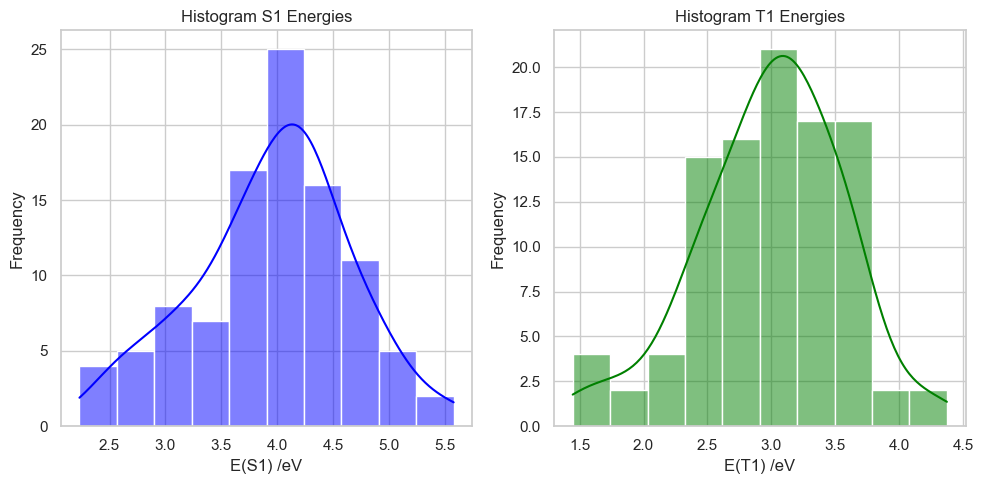

In [214]:
path = "./data/TADF_100.txt" #location of data

full_dataset = MFDataset(path)

full_dataset_loaded = DataLoader(full_dataset, batch_size=32, shuffle=True)

all_labels = []
for _, labels in full_dataset_loaded:
    all_labels.extend(labels)

# Convert the list of labels to a PyTorch tensor
all_labels = torch.stack(all_labels)

# Extract label 1 and label 2
label1 = all_labels[:, 0]
label2 = all_labels[:, 1]

# Set seaborn style
sns.set(style="whitegrid")

# Plot histograms using seaborn
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(label1, bins=10, kde=True, color='blue')
plt.title('Histogram S1 Energies')
plt.xlabel('E(S1) /eV')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(label2, bins=10, kde=True, color='green')
plt.title('Histogram T1 Energies')
plt.xlabel('E(T1) /eV')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [227]:
print(f"S1 mean energy: {torch.std_mean(label1)[1].item():.3f} eV. Standard deviation: {torch.std_mean(label1)[0].item():.3f} eV")
print(f"T1 mean energy: {torch.std_mean(label2)[1].item():.3f} eV. Standard deviation: {torch.std_mean(label2)[0].item():.3f} eV")

S1 mean energy: 3.954 eV. Standard deviation: 0.696 eV
T1 mean energy: 2.993 eV. Standard deviation: 0.571 eV


Next, the dataset is split into 8:1:1 for training, validation, and testing sets. A validation set is used to check how well the model performs on unseen data during training and prevent overfitting. The test set will then be used after training to fully assess the model's performance on completely unseen data.

In [237]:
#Splitting dataset 8:1L1
total_size = len(full_dataset)
train_size = int(0.8*total_size)
validation_size = int(0.1*total_size)
test_size = total_size - (train_size + validation_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size, test_size])

#Create DataLoaders for training, validation, & testing
bs = 50

train_dataloader = DataLoader(train_dataset, batch_size = bs, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = bs, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = bs, shuffle = False)

In [273]:
#Number of iterations per epoch

print("Number of iterations per epoch: ", total_size/bs)

Number of iterations per epoch:  2.0


In [238]:
first_batch = next(iter(train_dataloader))

# Check the shape of the first batch
input_size = first_batch[0].shape[1:]  # Excluding the batch dimension
print("Input size:", input_size)

Input size: torch.Size([1024])


### Defining the Model

The model used will be a neural network, specifially a multilayer perceptron (MLP). A rudimentary MLP will be built first before reproducing the MLP employed in the literature. The hyperparameters for the MLP employed by Kim, Kim, & Kim are shown below:

- Dimension of hidden layers: 1869
- Number of hidden layers: 7
- Dropout p: 0.0
- Number of linear layers of predictor: 1
- Learning rate: 10<sup>-3.5075</sup>   

#### Model with training loop only
The following model aims to minimise the training set error only (can lead to overfitting)

In [343]:
#Rudimentary MLP model
class MLP_1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [344]:
input_size = 1024 #Size of input features (1024 bit MFPs)
hidden_size = 64 #Size of hidden layers
output_size = 2 #Size of output size = 1 for regression

model_1 = MLP_1(input_size, hidden_size, output_size)

loss_funct = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

num_epochs = 100


loss_list = []
for epoch in range(num_epochs):
    if epoch % 20 == 0:
        print("Epoch ", epoch)
    batch = 1
    for batch_inputs, batch_targets in train_dataloader:
        batch_inputs = batch_inputs.to(torch.float32)
        batch_targets = batch_targets.to(torch.float32)
        
        optimizer.zero_grad() #clears gradients calculated from last batch
        batch_outputs = model_1(batch_inputs)
        loss = loss_funct(batch_outputs, batch_targets)
        loss.backward()
        optimizer.step()

        loss_list.append(float(loss))
        if epoch % 20 == 0:
            print("Batch: ", batch, " loss: ", loss)
        batch += 1
    if epoch % 20 == 0:
        print(" ")


Epoch  0
Batch:  1  loss:  tensor(11.9088, grad_fn=<MseLossBackward0>)
Batch:  2  loss:  tensor(11.7495, grad_fn=<MseLossBackward0>)
 
Epoch  20
Batch:  1  loss:  tensor(0.4826, grad_fn=<MseLossBackward0>)
Batch:  2  loss:  tensor(0.6430, grad_fn=<MseLossBackward0>)
 
Epoch  40
Batch:  1  loss:  tensor(0.0915, grad_fn=<MseLossBackward0>)
Batch:  2  loss:  tensor(0.0688, grad_fn=<MseLossBackward0>)
 
Epoch  60
Batch:  1  loss:  tensor(0.0120, grad_fn=<MseLossBackward0>)
Batch:  2  loss:  tensor(0.0078, grad_fn=<MseLossBackward0>)
 
Epoch  80
Batch:  1  loss:  tensor(0.0017, grad_fn=<MseLossBackward0>)
Batch:  2  loss:  tensor(0.0006, grad_fn=<MseLossBackward0>)
 


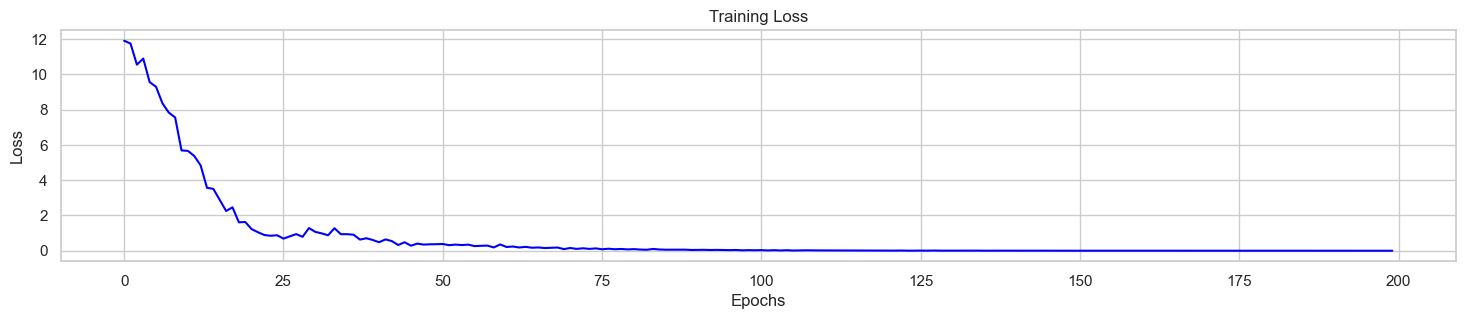

In [347]:
plt.figure(figsize=(18,3)) 
plt.plot(loss_list, c="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

#### Training model with validation set

In [369]:
a7 = torch.tensor([0, 2, 1, 3])
n7 = torch.tensor([0, 1, 2, 3])

r2 = R2Score()
r2.update(a7,n7)
r2.compute()

tensor(0.6000)

In [350]:
input_size = 1024 #Size of input features (1024 bit MFPs)
hidden_size = 64 #Size of hidden layers
output_size = 2 #Size of output size = 1 for regression

model_1 = MLP_1(input_size, hidden_size, output_size)

loss_funct = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)


#Training Loop (iterates over batches)
def train(model, iterator, optimizer, loss_funct):
    
    epoch_loss = 0
    r2_score = []
    model.train() #Set model to training mode

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(torch.float32) #MFP
        y = y.to(torch.float32) #S1 & T1 energies

        optimizer.zero_grad() #clears gradients calculated from last batch

        y_pred = model(x)
        loss = loss_funct(y_pred, y)
        loss.backward() #claculate gradient of loss
        optimizer.step() #update parameters by taking an optimizer step

        r2 = R2Score()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


#Evaluation Loop
#Similar to training loop but gradients are not calculated (with torch.no_grad() uses less memory)
def evaluate(model, iterator, loss_funct):

    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(torch.float32) #MFP
            y = y.to(torch.float32) #S1 & T1 energies

            y_pred = model(x)
            loss = loss_funct(y_pred, y)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [351]:
epochs = 101

best_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc="Training Model", unit="epoch"):

    start_time = time.monotonic()

    train_loss = train(model_1, train_dataloader, optimizer, loss_funct)
    valid_loss = evaluate(model_1, val_dataloader, loss_funct)

    train_losses.append(float(train_loss))
    val_losses.append(float(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f}")
        print(f"\t Val. Loss: {valid_loss:.3f}")

Training Model:   0%|          | 0/101 [00:00<?, ?epoch/s]

Epoch: 0 | Epoch Time: 0m 0s
	Train Loss: 12.778
	 Val. Loss: 10.810


Training Model:  21%|██        | 21/101 [00:00<00:03, 22.50epoch/s]

Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.643
	 Val. Loss: 0.349


Training Model:  39%|███▊      | 39/101 [00:01<00:03, 19.06epoch/s]

Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.092
	 Val. Loss: 0.254


Training Model:  59%|█████▉    | 60/101 [00:02<00:01, 21.22epoch/s]

Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.009
	 Val. Loss: 0.226


Training Model:  80%|████████  | 81/101 [00:03<00:00, 22.03epoch/s]

Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.001
	 Val. Loss: 0.218


Training Model: 100%|██████████| 101/101 [00:04<00:00, 20.86epoch/s]

Epoch: 100 | Epoch Time: 0m 0s
	Train Loss: 0.000
	 Val. Loss: 0.218


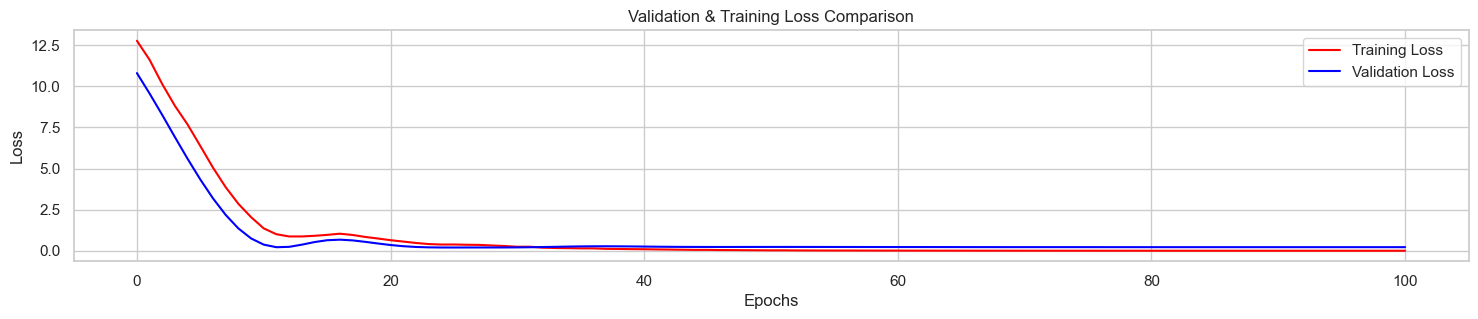

In [352]:
plt.figure(figsize=(18, 3)) 

# Plot the first line
plt.plot(train_losses, c="red", label="Training Loss")

# Plot the second line
plt.plot(val_losses, c="blue", label="Validation Loss")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation & Training Loss Comparison")
plt.legend()  # Show legend with labels

plt.show()

In [342]:
test_loss = evaluate(model_1, test_dataloader, loss_funct)
print(f"MSE on test set:  {test_loss:.4f}")

MSE on test set:  0.4754


Predit just one data with model

In [378]:
data_1_x = test_dataset[0][0] #First test MFP
data_1_x = torch.tensor(data_1_x, dtype = torch.float32) #Convert to tensor of appropriate data type

model_1.eval()

# Pass the input feature through the model to get the predicted output
with torch.no_grad():
    predicted_output = model_1(data_1_x.unsqueeze(0))  # Unsqueeze to add batch dimension

# You can now use the predicted output for further analysis or comparison
print("Predicted Energies:", predicted_output)
print("Actual Energies: ", test_dataset[0][1])

Predicted Energies: tensor([[3.7506, 2.9069]])
Actual Energies:  [4.2755 3.0434]


In [ ]:


for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        inputs = inputs.to(torch.float32)
        targets = targets.to(torch.float32)

        optimizer.zero_grad()
        outputs = model_1(inputs)
        loss = loss_funct(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Implement MLP per layer then larger MLP model which combines previous mlp model for each layer (as in paper)

In [146]:
#Sandbox

ln_m = pd.read_csv("./data/TADF_100.txt", sep ="\t", header=None)

ln_m.columns = ["ID", "SMILES","LUMO", "HOMO", "E(S1)", "E(T1)"]
#ln_m = ln_m.drop(ln_m.columns[[0, 2,3]], axis = 1)
ln_m = ln_m.drop(columns=["LUMO", "HOMO", "ID"])
ln_m["E(S1)"] = ln_m["E(S1)"].astype(float)
#ln_m.columns = ["SMILES", "E(S1)", "E(T1)"]
ln_m["Molecules"] = ln_m["SMILES"].apply(lambda x: Chem.MolFromSmiles(x)) #Add column of Molecular objects

def calculate_MFP(molecule):
    fp = AllChem.GetMorganFingerprintAsBitVect(molecule, 3, nBits=1024)
    nf = fp.ToList() #ToString
    return nf

ln_m["MFP"] = ln_m["Molecules"].apply(calculate_MFP)

tFP = torch.tensor(ln_m["E(S1)"])


mfps = np.array(ln_m["MFP"].tolist())

e1 = np.array(ln_m["E(S1)"])

es = np.column_stack((ln_m["E(S1)"], ln_m["E(T1)"]))


es[2]

array([3.3161, 2.862 ])

In [126]:
data2 = pd.read_csv("./data/TADF_100.txt", sep ="\t", header=None)
data2.columns = ["ID", "SMILES","LUMO", "HOMO", "E(S1)", "E(T1)"]

data2[:50].shape

(50, 6)

In [123]:
t2e = torch.tensor(data2["E(S1)"])

t2e

tensor([4.3709, 3.3935, 3.3161, 2.8377, 2.5995, 2.7747, 3.9396, 3.6299, 3.8147,
        2.5545, 4.2606, 4.0424, 3.5690, 4.8567, 4.7764, 5.2336, 4.9503, 4.1364,
        4.3195, 4.3711, 4.4265, 3.0374, 3.7318, 3.7503, 4.1681, 5.0360, 4.4768,
        3.5866, 4.6204, 2.2312, 3.7114, 2.5164, 3.6205, 4.8055, 4.2777, 4.8762,
        3.7835, 3.1035, 4.0869, 4.2755, 3.1495, 4.0349, 4.1388, 3.6710, 4.3421,
        4.2223, 5.5776, 4.4229, 4.9784, 4.3907, 4.0337, 2.7326, 3.6995, 4.2216,
        3.9274, 3.1655, 3.6429, 4.2574, 4.3757, 4.7660, 4.6781, 3.6457, 3.9980,
        4.6437, 3.0892, 3.9398, 3.1274, 5.5668, 3.6753, 3.9542, 5.1761, 2.9179,
        4.7379, 4.0370, 4.3602, 3.7369, 4.6683, 3.6528, 4.0032, 3.2471, 4.6693,
        4.2188, 4.3005, 4.1960, 4.1998, 4.0301, 4.1592, 3.5143, 3.2559, 3.1739,
        4.1005, 3.6665, 3.3450, 2.4975, 4.0939, 4.4529, 2.6862, 4.2015, 3.8866,
        4.2267], dtype=torch.float64)